# sanity check (agreement, crazy annotators)

## check agreement

In [10]:
# replace the yes with no if confidence level is less than or equal to 4
import csv
import os

batch_folder = 'batches'
annotation_csv_filename = f'14_finished.csv'
new_annot_csv_filename = f'new_{annotation_csv_filename}'
annotation_csv_filepath = os.path.join(batch_folder, annotation_csv_filename)
new_annot_csv_filepath = os.path.join(batch_folder, new_annot_csv_filename)
conf_threshold = 3.0
instances = []
with open(annotation_csv_filepath, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if int(row['Answer.Q2']) <= conf_threshold:
            row['Answer.Q1'] = 'No'
        instances.append(row)
        
with open(new_annot_csv_filepath, 'w') as csvfile:
    column_names = list(instances[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=column_names)
    writer.writeheader()
    for instance in instances:
        writer.writerow(instance)

In [11]:
from annotation_helper import *

# calculate Krippendorf's Alpha
workers_removed = []
# annotation_csv = f'batches/14_finished.csv'
annotation_csv = new_annot_csv_filepath
annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
k_alpha = calculate_krippendorff(annotation_list)
print(f"Krippendorf's Alpha: {k_alpha}, # of annotators: {len(annotators)}")

annotations_of_worker = read_annotation_of_worker(annotation_csv)
crazy_annotators = find_crazy_annotator(annotations_of_worker, max_inv_percentage=0.9, min_seconds=5)
print("Crazy annotators:", crazy_annotators)

Krippendorf's Alpha: -0.03446284174046976, # of annotators: 42
Crazy annotators: {}


In [12]:
from annotation_helper import *
from collections import defaultdict, Counter

loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'

workers_removed = []
k_threshold = 0.6

# generate the file to use MACE, the generated file is 'annotation_list.csv'
annotation_list_csvfilepath = 'annotation_list.csv'
annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
save_annotation_list(annotation_list, annotation_list_csvfilepath)

# run MACE
mace_prefix = f"check"
!java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

# load the competence file and prediction file
competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
competence_annotators = read_competence(competence_file, annotators)
mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
predictions = read_prediction(mace_prediction_file)

raw_preds = {}
for index, hitid in enumerate(hitids):
    pred = predictions[index]
    raw_preds[hitid] = pred

max_num_instance = len([x[0] for x in annotation_list])

# get the workers_removed
print("-" * 60)
print("The Krippendorf's Alpha threshold is {}".format(k_threshold))
workers_removed = []
for index, score_annotator in enumerate(competence_annotators):
    rank = index + 1
    score, annotator = score_annotator[0], score_annotator[1]

    # calculate Krippendorf's Alpha
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    k_alpha = calculate_krippendorff(annotation_list)

    # if calculated alpha is lower than the threshold, then continue to remove the annotators
    if k_alpha <= k_threshold:
#         print(f"Current k_alpha: {k_alpha}")
        workers_removed.append(annotator)
    else:
        print("The overall k_alpah is {:.2f}".format(k_alpha))
        break

print("You have removed {} annotators".format(len(workers_removed)))

# calculate the statistics
filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
temp = defaultdict(list)
for index, hitid in enumerate(hitids):
    mace_prediction = predictions[index]
    if hitid in filtered_annotations_of_instance.keys():
        annots = filtered_annotations_of_instance[hitid]
        annots['adjudicated_label'] = mace_prediction
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp[num_annotators].append(mace_prediction)
    else:
        temp[0].append(raw_preds[hitid])
        continue        
        
# print the statistics of gold instances
print("-" * 60)
yes_count = 0
label_count = 0
for key in [5, 4, 3, 2, 1, 0]:
    value = temp[key]
    value_count = Counter(value)
    yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
    print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
        key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
    ))
    if key != 0:
        yes_count += value_count['Yes']
        label_count += len(value)

annot_context = {}

for _, annot in filtered_annotations_of_instance.items():
    instance_id = annot['Input.instance_id']
    annot_context[instance_id] = annot

Saving the annotation list for using the MACE...
Done.
------------------------------------------------------------
The Krippendorf's Alpha threshold is 0.6
The overall k_alpah is nan
You have removed 18 annotators
------------------------------------------------------------
# of annotations after filtering: 5, # of tweets: 2	5.0%	Yes: 2    || 100.00%
# of annotations after filtering: 4, # of tweets: 8	20.0%	Yes: 8    || 100.00%
# of annotations after filtering: 3, # of tweets: 16	40.0%	Yes: 16   || 100.00%
# of annotations after filtering: 2, # of tweets: 10	25.0%	Yes: 10   || 100.00%
# of annotations after filtering: 1, # of tweets: 4	10.0%	Yes: 4    || 100.00%
# of annotations after filtering: 0, # of tweets: 0	0.0%	Yes: 0    || 0.00%


In [7]:
from annotation_helper import *
from collections import defaultdict, Counter

# replace the yes with no if confidence level is less than or equal to 4
import csv
import os

batch_folder = 'batches'
annotation_csv_filename = f'8_finished.csv'
new_annot_csv_filename = f'check.csv'
annotation_csv_filepath = os.path.join(batch_folder, annotation_csv_filename)
new_annot_csv_filepath = os.path.join(batch_folder, new_annot_csv_filename)
conf_threshold = 3.0
instances = []
with open(annotation_csv_filepath, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if int(row['Answer.Q2']) <= conf_threshold:
            row['Answer.Q1'] = 'No'
        instances.append(row)
        
with open(new_annot_csv_filepath, 'w') as csvfile:
    column_names = list(instances[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=column_names)
    writer.writeheader()
    for instance in instances:
        writer.writerow(instance)
        
##############################        
loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'
annotation_csv = new_annot_csv_filepath

k_threshold = 0.6

print("-" * 60)
print("The Krippendorf's Alpha threshold is {}".format(k_threshold))

# run MACE
k_alpha = 0.0
workers_removed = []
while k_alpha < k_threshold:

    # generate the file to use MACE, the generated file is 'annotation_list.csv'
    annotation_list_csvfilepath = 'annotation_list.csv'
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    save_annotation_list(annotation_list, annotation_list_csvfilepath)

    mace_prefix = f"check"
    !java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

    # load the competence file and prediction file
    competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
    competence_annotators = read_competence(competence_file, annotators)
    mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
    predictions = read_prediction(mace_prediction_file)

    raw_preds = {}
    for index, hitid in enumerate(hitids):
        pred = predictions[index]
        raw_preds[hitid] = pred

    max_num_instance = len([x[0] for x in annotation_list])

    # get the workers_removed
    workers_removed.append(competence_annotators[0][1])
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    
    # calculate Krippendorf's Alpha
    k_alpha = calculate_krippendorff(annotation_list)

    # if calculated alpha is lower than the threshold, then continue to remove the annotators
    if k_alpha <= k_threshold:
        print(f"Current k_alpha: {k_alpha}")
    else:
        print("The overall k_alpah is {:.2f}".format(k_alpha))
        break

print("You have removed {} annotators".format(len(workers_removed)))

# calculate the statistics
filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
temp = defaultdict(list)
for index, hitid in enumerate(hitids):
    mace_prediction = predictions[index]
    if hitid in filtered_annotations_of_instance.keys():
        annots = filtered_annotations_of_instance[hitid]
        annots['adjudicated_label'] = mace_prediction
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp[num_annotators].append(mace_prediction)
    else:
        temp[0].append(raw_preds[hitid])
        continue        
        
# print the statistics of gold instances
print("-" * 60)
yes_count = 0
label_count = 0
for key in [5, 4, 3, 2, 1, 0]:
    value = temp[key]
    value_count = Counter(value)
    yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
    print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
        key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
    ))
    if key != 0:
        yes_count += value_count['Yes']
        label_count += len(value)

------------------------------------------------------------
The Krippendorf's Alpha threshold is 0.6
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.016175976127432268
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.01621708773025965
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.022002071450866967
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.023536676770200438
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.027705903559802736
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.026698030401302697
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.032388640387662204
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.03726446342543799
Saving the annotation list for using the MACE...
Done.
Current k_alpha: 0.0448093301034479
Saving the annotation list for using the MACE...
Done.
Current k_

## Calculate the confusion matrix between the tweets with and without context

Load the tweets without context (only anchor tweets)

In [39]:
import os
import json

annot_nocontext_folder = '/home/zhaomin/Documents/github/loc_tmp/saved_anchors/annotation'
annot_nocontext_filename = 'full_gold.json'
annot_nocontext_filepath = os.path.join(annot_nocontext_folder, annot_nocontext_filename)

annot_nocontext = {}
with open(annot_nocontext_filepath, 'r') as jsonfile:
    lines = jsonfile.read().split("\n")[:-1]
    for line in lines:
        instance = json.loads(line)
        # add the instance_id so that two versions of annotation can be aligned
        instance_id = '_'.join(instance['anchor_id'].split("_")[:-1])
        instance['instance_id'] = instance_id
        annot_nocontext[instance_id] = instance

Draw the confusion matrix

[Text(0, 0.5, 'tweets_with_context')]

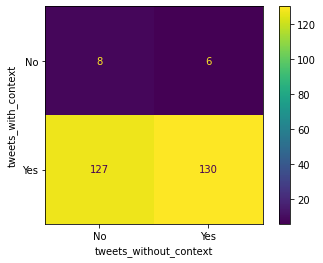

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels_nocontext, labels_context = [], []
for instance_id, instances_context in annot_context.items():
    instance_nocontext = annot_nocontext[instance_id]
    label_nocontext = instance_nocontext['adjudicated_label']
    if label_nocontext == 'Other':
        label_nocontext = 'No'
    
    # always set label for tweets with context as Yes
    label_context = instances_context['adjudicated_label']
    
    labels_nocontext.append(label_nocontext)
    labels_context.append(label_context)
    
cm = confusion_matrix(labels_context, labels_nocontext)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
fig = disp.plot()
fig.ax_.set(xlabel="tweets_without_context")
fig.ax_.set(ylabel="tweets_with_context")

In [102]:
# get the adjudicated label
instances_republish = []
instances_keep = []

filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed=workers_removed)
annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed=[])

# prepare for silver instances
mace_predictions = {hitid: predictions[index] for index, hitid in enumerate(hitids)}
for hitid in annotations_of_instance.keys():
    if hitid not in filtered_annotations_of_instance.keys():
        annots = raw_annotations_of_instance[hitid]
        instances_republish.append(annots)
    else:
        mace_prediction = mace_predictions[hitid]
        filtered_annotations_of_instance[hitid]['adjudicated_label'] = mace_prediction

# prepare for gold instance
for hitid, annot in filtered_annotations_of_instance.items():
    temp_dict = annot
    temp_dict['HITId'] = hitid
    instances_keep.append(temp_dict)

print(f"Among {len(instances_keep)+len(instances_republish)} instances, gold: {len(instances_keep)}, silver: {len(instances_republish)}")

Among 6540 instances, gold: 1388, silver: 5152


In [103]:
# save the kept instances and republished instances into the json file
import json

instances_keep_filename = f"{data_type}_gold.json"
instances_republish_filename = f"{data_type}_silver.json"

with open(instances_keep_filename, 'w') as jsonfile:
    for ele in instances_keep:
        jsonfile.write(json.dumps(ele))
        jsonfile.write("\n")

with open(instances_republish_filename, 'w') as jsonfile:
    for ele in instances_republish:
        jsonfile.write(json.dumps(ele))
        jsonfile.write("\n")

## =============================================================

In [14]:
# write the instances into csv file
annotation2_folderpath = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/annotation3'

annotation2_filename = 'part1_annotation3_whole_batch.csv'
annotation2_filepath = os.path.join(annotation2_folderpath, annotation2_filename)
with open(annotation2_filepath, 'w') as csvfile:
    column_names = ['anchor_id', 'event', 'anchor_location', 'anchor_url']
    writer = csv.DictWriter(csvfile, fieldnames=column_names)
    writer.writeheader()
    
    for instance in instances_republish:
        ele = {
            'anchor_id': instance['Input.anchor_id'],
            'event': instance['Input.event'],
            'anchor_location': instance['Input.anchor_location'],
            'anchor_url': instance['Input.anchor_url']
        }
        writer.writerow(ele)

In [17]:
import csv
import os

big_batch_folder = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/annotation3'
big_batch_filename = 'part1_annotation3_whole_batch.csv'
big_batch_path = os.path.join(big_batch_folder, big_batch_filename)
small_batches_folder = os.path.join(big_batch_folder, 'small_batches')
num_instances = 4274
with open(big_batch_path, 'r') as csvfile:
    count = 0
    temp = []
    reader = csv.DictReader(csvfile)
    for row in reader:
        temp.append(row)
        count += 1
        if count % 500 == 0:
            small_batch_filename = '{}.csv'.format(int(count // 500))
            small_batch_filepath = os.path.join(small_batches_folder, small_batch_filename)
            with open(small_batch_filepath, 'w') as small_csv:
                column_names = list(row.keys())
                writer = csv.DictWriter(small_csv, fieldnames=column_names)
                writer.writeheader()
                
                for ele in temp:
                    writer.writerow(ele)
            temp.clear()
        if count == num_instances:
            small_batch_filename = '{}.csv'.format((num_instances//500)+1)
            small_batch_filepath = os.path.join(small_batches_folder, small_batch_filename)
            with open(small_batch_filepath, 'w') as small_csv:
                column_names = list(row.keys())
                writer = csv.DictWriter(small_csv, fieldnames=column_names)
                writer.writeheader()
                
                for ele in temp:
                    writer.writerow(ele)
            temp.clear()
            print("done")
            break

done


## check crazy annotators

In [49]:
from annotation_helper import *
from collections import Counter

annotation_csv = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/annotation_anchor_notext/small_batches/14_finished.csv'
annotations_of_worker = read_annotation_of_worker(annotation_csv)

min_secs = 5
max_inv = .95

crazy_annotators = {}
seconds_output = []
for worker, annots in annotations_of_worker.items():
    labels = [x['Answer.Q1'] for x in annots.values()]
    labels_count = Counter(labels)
    if 'Inv' in labels_count.keys():
        if float(labels_count['Inv'] / len(labels)) > max_inv and len(labels) > 5:
            crazy_annotators[worker] = 'too many invalid'
    for hitid, annot in annots.items():
        if int(annot['WorkTimeInSeconds']) < min_secs:
            crazy_annotators[worker] = 'less than 5 seconds'
            seconds = [int(x['WorkTimeInSeconds']) for x in annots.values()]
            seconds_output.append([worker, seconds])
            print(seconds)
            print()
            break

In [50]:
for x in seconds_output:
    print("instances annotated: {}, avg time: {}".format(len(x[1]), sum(x[1])/len(x[1])))

In [51]:
crazy_annotators

{}

In [48]:
from annotation_helper import *
from collections import Counter
from sklearn.metrics import cohen_kappa_score

workers_removed = []

# 1. load the annotation csv file
annotation_csv = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/small_batches/2_1000samples_finished.csv'
annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
annotations_of_worker = read_annotation_of_worker(annotation_csv)

In [49]:
# check if instance has majority label. If yes, then add it. If no, then remove this instance.
for hitid in list(annotations_of_instance.keys()):
    annots = annotations_of_instance[hitid]
    labels = [annots[x] for x in annots.keys() if x.startswith("Answer.Q1")]
    labels_count = Counter(labels).most_common()
    if len(labels_count) > 1:
        if labels_count[0][1] != labels_count[1][1]:
            majority_label = labels_count[0][0]
        else:
            del annotations_of_instance[hitid]
            continue
    else:
        majority_label = labels[0]
    annotations_of_instance[hitid]['majority_label'] = majority_label

In [52]:
kappa_threshold = 0.4

for kappa_threshold in [0.3, 0.4, 0.5, 0.6]:
    print("Lowest Cohen's Kappa: {}".format(kappa_threshold))
    worker_kappa = []
    for worker, annots in annotations_of_worker.items():
        labels = []
        major_labels = []
        for hitid in annots.keys():
            if hitid not in annotations_of_instance.keys():
                continue
            annotation = annotations_of_instance[hitid]
            major_labels.append(annotation['majority_label'])
            labels.append(annotation['Answer.Q1_{}'.format(worker)])
        kappa = float(format(cohen_kappa_score(major_labels, labels), '.2f'))
        worker_kappa.append([worker, kappa, len(labels)])

    workers_removed = [x[0] for x in worker_kappa if x[1] < kappa_threshold]

    filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
    instances_no_major = []
    instances_with_major = []
    for hitid, annots in filtered_annotations_of_instance.items():
        labels = [annots[x] for x in annots.keys() if x.startswith("Answer.Q1")]
        labels_count = Counter(labels).most_common()
        if len(labels_count) > 1:
            if labels_count[0][1] == labels_count[1][1]:
                instances_no_major.append(hitid)
                continue
        instances_with_major.append([hitid, labels_count[0][0]])
    major_labels = [x[1] for x in instances_with_major]
    major_labels_count = Counter(major_labels)

    annotation_list, annotators = get_annotation_list(annotation_csv, workers_removed)
    k_alpha = calculate_krippendorff(annotation_list)
    print("Instances w/ majority label: {}. Yes: {}, No: {}, Inv: {}".format(
        len(instances_with_major), major_labels_count['Yes'],
        major_labels_count['No'], major_labels_count['Inv']))
    print("Instances w/o majority label: {}".format(len(instances_no_major)))
    print("Krippendorf's Alpha: {:.2f}\n".format(k_alpha))

Lowest Cohen's Kappa: 0.3
Instances w/ majority label: 833. Yes: 572, No: 158, Inv: 103
Instances w/o majority label: 166
Krippendorf's Alpha: 0.26

Lowest Cohen's Kappa: 0.4
Instances w/ majority label: 825. Yes: 605, No: 121, Inv: 99
Instances w/o majority label: 160
Krippendorf's Alpha: 0.32

Lowest Cohen's Kappa: 0.5
Instances w/ majority label: 785. Yes: 584, No: 102, Inv: 99
Instances w/o majority label: 124
Krippendorf's Alpha: 0.41

Lowest Cohen's Kappa: 0.6
Instances w/ majority label: 648. Yes: 467, No: 89, Inv: 92
Instances w/o majority label: 57
Krippendorf's Alpha: 0.52



In [1]:
from annotation_helper import *

annotation_csv = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/small_batches/2_1000samples_finished.csv'
annotation_list, annotators = get_annotation_list(annotation_csv, workers_removed=[])

competence_file = '/home/zhaomin/Documents/github/loc_tmp/competence'
competence_annotators = read_competence(competence_file, annotators)
competence_annotators = sorted([[float(x[0]), x[1]] for x in competence_annotators], key=lambda x: x[0])

In [3]:
for k_threshold in [0.5, 0.55, 0.6]:
    print("The Krippendorf's Alpha threshold is {}".format(k_threshold))
    workers_removed = []
    for index, score_annotator in enumerate(competence_annotators):
        rank = index + 1
        score, annotator = score_annotator[0], score_annotator[1]
        print(score)
        
        # calculate Krippendorf's Alpha
        annotation_list, annotators = get_annotation_list(annotation_csv, workers_removed)
        k_alpha = calculate_krippendorff(annotation_list)
        
        # if calculated alpha is lower than the threshold, then continue to remove the annotators
        if k_alpha <= k_threshold:
            workers_removed.append(annotator)
            print("Annotators removed: {}, alpha: {}\n".format(len(workers_removed), k_alpha))
        else:
            print("You have removed {} annotators".format(len(workers_removed)))
            break

The Krippendorf's Alpha is 0.5
0.0004308646166870991
Annotators removed: 1, alpha: 0.1260306199272302

0.0011046291773712184
Annotators removed: 2, alpha: 0.1270526186095008

0.004625347897433776
Annotators removed: 3, alpha: 0.1273793622611944

0.004716401073467311
Annotators removed: 4, alpha: 0.12730017555718787

0.00723862215099571
Annotators removed: 5, alpha: 0.12699713943221735

0.00963786225166904
Annotators removed: 6, alpha: 0.12672582159653667

0.009718005241722748
Annotators removed: 7, alpha: 0.12667645861783672

0.011864193049259411
Annotators removed: 8, alpha: 0.12713541429503838

0.022979882168841153
Annotators removed: 9, alpha: 0.12459549170738304

0.02601708597651916
Annotators removed: 10, alpha: 0.12489719784611952

0.028210696126762965
Annotators removed: 11, alpha: 0.12269623859757961

0.03894159565014327
Annotators removed: 12, alpha: 0.12261609194670109

0.05715660631759924
Annotators removed: 13, alpha: 0.1225358975710995

0.05744874936663537
Annotators remov

Annotators removed: 117, alpha: 0.30512292557591125

0.750532420698651
Annotators removed: 118, alpha: 0.2970248800959232

0.7749726496908738
Annotators removed: 119, alpha: 0.31190783807062883

0.7795024156910098
Annotators removed: 120, alpha: 0.31190783807062883

0.7843649414173993
Annotators removed: 121, alpha: 0.3192521288411698

0.8258742930874912
Annotators removed: 122, alpha: 0.3170576332159185

0.8388747801779823
Annotators removed: 123, alpha: 0.33667264364231697

0.8841579576040611
Annotators removed: 124, alpha: 0.33447785934170027

0.8900684443774197
Annotators removed: 125, alpha: 0.3467619472979009

0.8954828772197556
Annotators removed: 126, alpha: 0.27751806204844875

0.8966606964956302
Annotators removed: 127, alpha: 0.2504278379920136

0.9016230403164199
Annotators removed: 128, alpha: 0.2702518720217836

0.9060001091241634
Annotators removed: 129, alpha: 0.3109425785482123

0.920872329713276
Annotators removed: 130, alpha: -0.1875

0.936511312816127
Annotators rem

Annotators removed: 100, alpha: 0.2555153972554248

0.6422687145398623
Annotators removed: 101, alpha: 0.2555153972554248

0.6423855357613012
Annotators removed: 102, alpha: 0.2605116674731621

0.6432742137804844
Annotators removed: 103, alpha: 0.261420317588428

0.6436093404813182
Annotators removed: 104, alpha: 0.261420317588428

0.6436093404813182
Annotators removed: 105, alpha: 0.2585367292365772

0.6437545162472579
Annotators removed: 106, alpha: 0.25539030058118006

0.6439357678938101
Annotators removed: 107, alpha: 0.2603475253417986

0.6477383704914464
Annotators removed: 108, alpha: 0.25259932986359135

0.6495858608530655
Annotators removed: 109, alpha: 0.323114475098531

0.6713966482574266
Annotators removed: 110, alpha: 0.3244415038825528

0.6956917257923197
Annotators removed: 111, alpha: 0.3213524698536906

0.6978671085473207
Annotators removed: 112, alpha: 0.31877935854131745

0.708528123400297
Annotators removed: 113, alpha: 0.32687352731107855

0.7228619864509808
Annota

Annotators removed: 84, alpha: 0.253402395698726

0.5489458927259981
Annotators removed: 85, alpha: 0.25318410300985916

0.5495850670437457
Annotators removed: 86, alpha: 0.25487566710757303

0.554873005748071
Annotators removed: 87, alpha: 0.24540278789496217

0.5584379773195612
Annotators removed: 88, alpha: 0.24550487736717275

0.5646747291143163
Annotators removed: 89, alpha: 0.25126317309080404

0.5875223997432654
Annotators removed: 90, alpha: 0.25280074785140516

0.5927363038855264
Annotators removed: 91, alpha: 0.2518474231823776

0.5954647962473807
Annotators removed: 92, alpha: 0.24979255907902276

0.5966007717928093
Annotators removed: 93, alpha: 0.2333878311513642

0.6000886699575863
Annotators removed: 94, alpha: 0.2296088754153751

0.6097597748156753
Annotators removed: 95, alpha: 0.23343871521550186

0.6137504734343731
Annotators removed: 96, alpha: 0.2363178912667675

0.627026676321765
Annotators removed: 97, alpha: 0.24288610904372054

0.6296993434111676
Annotators rem

### split the large batch into many small batches

In [15]:
import csv
import os

max_instances = 6540

big_batch_folder = '/home/zhaomin/Documents/github/loc_tmp/batches_part1/annotation_anchor_noimage'
big_batch_filename = 'part1_noimage.csv'
big_batch_path = os.path.join(big_batch_folder, big_batch_filename)
with open(big_batch_path, 'r') as csvfile:
    count = 0
    temp = []
    reader = csv.DictReader(csvfile)
    for row in reader:
        temp.append(row)
        count += 1
        if count % 500 == 0:
            small_batch_filename = '{}.csv'.format(int(count // 500))
            small_batch_filepath = os.path.join(big_batch_folder, small_batch_filename)
            with open(small_batch_filepath, 'w') as small_csv:
                column_names = list(row.keys())
                writer = csv.DictWriter(small_csv, fieldnames=column_names)
                writer.writeheader()
                
                for ele in temp:
                    writer.writerow(ele)
            temp.clear()
        if count == max_instances:
            small_batch_filename = '{}.csv'.format((max_instances//500)+1)
            small_batch_filepath = os.path.join(big_batch_folder, small_batch_filename)
            with open(small_batch_filepath, 'w') as small_csv:
                column_names = list(row.keys())
                writer = csv.DictWriter(small_csv, fieldnames=column_names)
                writer.writeheader()
                
                for ele in temp:
                    writer.writerow(ele)
            temp.clear()
            break

# combine the batches into a large batch

In [63]:
import os
import csv

data_type = "notext"
batches_folderpath = f'/home/zhaomin/Documents/github/loc_tmp/batches_part1/annotation_anchor_{data_type}/small_batches'
batch_filenames = [x for x in os.listdir(batches_folderpath) if x.endswith("finished_replaced.csv")]
temp = []
for batch_filename in batch_filenames:
    batch_filepath = os.path.join(batches_folderpath, batch_filename)
    with open(batch_filepath, 'r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['RequesterFeedback'].lower() not in ['x', 'incomplete']:
                temp.append(row)

big_batch_filename = f'big_{data_type}.csv'
big_batch_filepath = os.path.join(batches_folderpath, big_batch_filename)
with open(big_batch_filepath, 'w', encoding='utf-8-sig') as csvfile:
    column_names = list(temp[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=column_names)
    writer.writeheader()
    
    for ele in temp:
        writer.writerow(ele)

# get the statistics of the cumulative batches

In [19]:
import os
import csv
from annotation_helper import *
from collections import Counter

num_batches = 14
conf_threshold = 4.0

# combine batches (also replace labels)
batch_folder = 'batches'
cumul_batch_filename = f'cumul_batches.csv'
batch_filenames = [x for x in os.listdir(batch_folder) if x.endswith('finished.csv') and int(x.split("_")[0]) <= num_batches]
instances = []
with open(cumul_batch_filename, 'w') as bigcsvfile:
    for batch_filename in batch_filenames:
        batch_filepath = os.path.join(batch_folder, batch_filename)
        with open(batch_filepath, 'r') as smallcsvfile:
            reader = csv.DictReader(smallcsvfile)
            for row in reader:
                # replace 'Yes' with 'No' if confidence level is <= 3.0
                if int(row['Answer.Q2']) <= conf_threshold:
                    row['Answer.Q1'] = 'No'
                instances.append(row)
    column_names = list(instances[0].keys())
    writer = csv.DictWriter(bigcsvfile, fieldnames=column_names)
    writer.writeheader()
    for instance in instances:
        writer.writerow(instance)
        
# use the big csv file to filter annotations using MACE
loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'
annotation_csv = cumul_batch_filename

workers_removed = []
k_threshold = 0.6

# generate the file to use MACE, the generated file is 'annotation_list.csv'
annotation_list_csvfilepath = 'annotation_list.csv'
annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
save_annotation_list(annotation_list, annotation_list_csvfilepath)

# run MACE
mace_prefix = f"check"
!java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

# load the competence file and prediction file
competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
competence_annotators = read_competence(competence_file, annotators)
mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
predictions = read_prediction(mace_prediction_file)

raw_preds = {}
for index, hitid in enumerate(hitids):
    pred = predictions[index]
    raw_preds[hitid] = pred

max_num_instance = len([x[0] for x in annotation_list])

# get the workers_removed
print("-" * 60)
print("The Krippendorf's Alpha threshold is {}".format(k_threshold))
workers_removed = []
for index, score_annotator in enumerate(competence_annotators):
    rank = index + 1
    score, annotator = score_annotator[0], score_annotator[1]

    # calculate Krippendorf's Alpha
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    k_alpha = calculate_krippendorff(annotation_list)

    # if calculated alpha is lower than the threshold, then continue to remove the annotators
    if k_alpha <= k_threshold:
        print(f"Current k_alpha: {k_alpha}")
        workers_removed.append(annotator)
    else:
        print("The overall k_alpah is {:.2f}".format(k_alpha))
        break

print("You have removed {} annotators".format(len(workers_removed)))

# calculate the statistics
filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
temp = defaultdict(list)
for index, hitid in enumerate(hitids):
    mace_prediction = predictions[index]
    if hitid in filtered_annotations_of_instance.keys():
        annots = filtered_annotations_of_instance[hitid]
        annots['adjudicated_label'] = mace_prediction
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp[num_annotators].append(mace_prediction)
    else:
        temp[0].append(raw_preds[hitid])
        continue        
        
# print the statistics of gold instances
print("-" * 60)
yes_count = 0
label_count = 0
for key in [5, 4, 3, 2, 1, 0]:
    value = temp[key]
    value_count = Counter(value)
    yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
    print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
        key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
    ))
    if key != 0:
        yes_count += value_count['Yes']
        label_count += len(value)

annot_context = {}

for _, annot in filtered_annotations_of_instance.items():
    instance_id = annot['Input.instance_id']
    annot_context[instance_id] = annot

Saving the annotation list for using the MACE...
Done.
------------------------------------------------------------
The Krippendorf's Alpha threshold is 0.6
Current k_alpha: 0.011435714828888721
Current k_alpha: 0.017880553887436812
Current k_alpha: 0.014454901818572674
Current k_alpha: 0.01029976278778566
Current k_alpha: 0.014665849063994263
Current k_alpha: 0.013238670821649756
Current k_alpha: 0.012992702403165524
Current k_alpha: 0.014519895895479529
Current k_alpha: 0.012720944491184438
Current k_alpha: 0.013281848374923966
Current k_alpha: 0.010017026566286336
Current k_alpha: 0.006710570271518113
Current k_alpha: 0.004163898406425615
Current k_alpha: 0.0003511004326406386
Current k_alpha: 0.0007898408187707595
Current k_alpha: -0.00032508085846183477
Current k_alpha: -0.0018958185513646697
Current k_alpha: -0.0021941100503268807
Current k_alpha: -0.0006448307564801414
Current k_alpha: 0.020227930275272366
Current k_alpha: 0.021686405733663205
Current k_alpha: 0.0179773213483294

ValueError: list.remove(x): x not in list

Draw the confusion matrix

[Text(0, 0.5, 'tweets_with_context')]

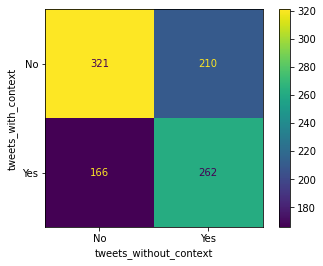

In [7]:
import os
import json
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

annot_nocontext_folder = '/home/zhaomin/Documents/github/loc_tmp/saved_anchors/annotation'
annot_nocontext_filename = 'full_gold.json'
annot_nocontext_filepath = os.path.join(annot_nocontext_folder, annot_nocontext_filename)

examples = defaultdict(list)
annot_nocontext = {}
with open(annot_nocontext_filepath, 'r') as jsonfile:
    lines = jsonfile.read().split("\n")[:-1]
    for line in lines:
        instance = json.loads(line)
        # add the instance_id so that two versions of annotation can be aligned
        instance_id = '_'.join(instance['anchor_id'].split("_")[:-1])
        instance['instance_id'] = instance_id
        annot_nocontext[instance_id] = instance

labels_nocontext, labels_context = [], []
for instance_id, instances_context in annot_context.items():
    instance_nocontext = annot_nocontext[instance_id]
    label_nocontext = instance_nocontext['adjudicated_label']
    if label_nocontext == 'Other':
        label_nocontext = 'No'
    
    # always set label for tweets with context as Yes
    label_context = instances_context['adjudicated_label']
    
    labels_nocontext.append(label_nocontext)
    labels_context.append(label_context)
    
    if label_context == 'Yes' and label_nocontext == 'No':
        examples['context_yes_nocontext_no'].append(instances_context)
    if label_context == 'Yes' and label_nocontext == 'Yes':
        examples['context_yes_nocontext_yes'].append(instances_context)
    if label_context == 'No' and label_nocontext == 'No':
        examples['context_no_nocontext_no'].append(instances_context)
    if label_context == 'No' and label_nocontext == 'Yes':
        examples['context_no_nocontext_yes'].append(instances_context)
    
cm = confusion_matrix(labels_context, labels_nocontext)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
fig = disp.plot()
fig.ax_.set(xlabel="tweets_without_context")
fig.ax_.set(ylabel="tweets_with_context")

### run MACE multiple times

In [7]:
import os
import csv
from annotation_helper import *
from collections import Counter

num_batches = 14
conf_threshold = 3.0
beam_size = 1

# combine batches (also replace labels)
batch_folder = 'batches'
cumul_batch_filename = f'cumul_batches.csv'
batch_filenames = [x for x in os.listdir(batch_folder) if x.endswith('finished.csv') and int(x.split("_")[0]) <= num_batches]
instances = []
with open(cumul_batch_filename, 'w') as bigcsvfile:
    for batch_filename in batch_filenames:
        batch_filepath = os.path.join(batch_folder, batch_filename)
        with open(batch_filepath, 'r') as smallcsvfile:
            reader = csv.DictReader(smallcsvfile)
            for row in reader:
                # replace 'Yes' with 'No' if confidence level is <= 3.0
                if int(row['Answer.Q2']) <= conf_threshold:
                    row['Answer.Q1'] = 'No'
                instances.append(row)
    column_names = list(instances[0].keys())
    writer = csv.DictWriter(bigcsvfile, fieldnames=column_names)
    writer.writeheader()
    for instance in instances:
        writer.writerow(instance)
        
# use the big csv file to filter annotations using MACE
loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'
annotation_csv = cumul_batch_filename

workers_removed = []
k_threshold = 0.6
k_alpha = 0.0
print("The Krippendorf's Alpha threshold is {}".format(k_threshold))
while k_alpha < k_threshold:
    
    # generate the file to use MACE, the generated file is 'annotation_list.csv'
    annotation_list_csvfilepath = 'annotation_list.csv'
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    save_annotation_list(annotation_list, annotation_list_csvfilepath)

    # run MACE
    mace_prefix = f"check"
    !java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

    # load the competence file and prediction file
    competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
    competence_annotators = read_competence(competence_file, annotators)
    mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
    predictions = read_prediction(mace_prediction_file)

    raw_preds = {}
    for index, hitid in enumerate(hitids):
        pred = predictions[index]
        raw_preds[hitid] = pred

    max_num_instance = len([x[0] for x in annotation_list])

    # get the workers_removed
    for i in range(beam_size):
        workers_removed.append(competence_annotators[i][1])

    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    
    # calculate Krippendorf's Alpha
    k_alpha = calculate_krippendorff(annotation_list)

    # if calculated alpha is lower than the threshold, then continue to remove the annotators
    if k_alpha <= k_threshold:
        print(f"Current k_alpha: {k_alpha}")
    else:
        print("The overall k_alpah is {:.2f}".format(k_alpha))
        break

print("You have removed {} annotators".format(len(workers_removed)))

# calculate the statistics
filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
temp = defaultdict(list)
for index, hitid in enumerate(hitids):
    mace_prediction = predictions[index]
    if hitid in filtered_annotations_of_instance.keys():
        annots = filtered_annotations_of_instance[hitid]
        annots['adjudicated_label'] = mace_prediction
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp[num_annotators].append(mace_prediction)
    else:
        temp[0].append(raw_preds[hitid])
        continue        
        
# print the statistics of gold instances
print("-" * 60)
yes_count = 0
label_count = 0
for key in [5, 4, 3, 2, 1, 0]:
    value = temp[key]
    value_count = Counter(value)
    yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
    print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
        key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
    ))
    if key != 0:
        yes_count += value_count['Yes']
        label_count += len(value)

annot_context = {}

for _, annot in filtered_annotations_of_instance.items():
    instance_id = annot['Input.instance_id']
    annot_context[instance_id] = annot

The Krippendorf's Alpha threshold is 0.6
Current k_alpha: 0.01081160260793057
Current k_alpha: 0.009927172298325626
Current k_alpha: 0.008553184338766728
Current k_alpha: 0.010028885804513998
Current k_alpha: 0.00935072578930185
Current k_alpha: 0.011161685282606304
Current k_alpha: 0.018647949908532135
Current k_alpha: 0.018008344988634017
Current k_alpha: 0.018426766788823268
Current k_alpha: 0.020660747462802442
Current k_alpha: 0.023925802319767042
Current k_alpha: 0.02490685033724649
Current k_alpha: 0.026977858460368154
Current k_alpha: 0.03035931554966098
Current k_alpha: 0.030722753188784035
Current k_alpha: 0.03410423063810175
Current k_alpha: 0.034820218667546365
Current k_alpha: 0.03252247744757486
Current k_alpha: 0.03186725205873486
Current k_alpha: 0.03372024702742238
Current k_alpha: 0.03320720600654292
Current k_alpha: 0.03221077544666595
Current k_alpha: 0.031287213946120995
Current k_alpha: 0.03037018314978923
Current k_alpha: 0.029642057172105996
Current k_alpha: 0.0

Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.4761376621630705
Current k_alpha: 0.506370523415978
Current k_alpha: 0.5035149051376232
Current k_alpha: 0.5035149051

### get the tables and confusion matrices of the cumulative batches (weighted averaged version)

In [9]:
import os
import csv
import numpy as np
from annotation_helper import *
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_batches = 14
conf_threshold = 4.0
        
# use the big csv file to filter annotations using MACE
loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'

# load the tweets without context
annot_nocontext_folder = '/home/zhaomin/Documents/github/loc_tmp/saved_anchors/annotation'
annot_nocontext_filename = 'full_gold.json'
annot_nocontext_filepath = os.path.join(annot_nocontext_folder, annot_nocontext_filename)
annot_nocontext = {}
with open(annot_nocontext_filepath, 'r') as jsonfile:
    lines = jsonfile.read().split("\n")[:-1]
    for line in lines:
        instance = json.loads(line)
        # add the instance_id so that two versions of annotation can be aligned
        instance_id = '_'.join(instance['anchor_id'].split("_")[:-1])
        instance['instance_id'] = instance_id
        annot_nocontext[instance_id] = instance


batch_folder = 'batches'
batch_filenames = [x for x in os.listdir(batch_folder) if x.endswith('finished.csv') and int(x.split("_")[0]) <= num_batches]
batch_filenames = sorted(batch_filenames, key=lambda x: int(x.split("_")[0]))
annot_context = {}
for batch_filename in batch_filenames:
    
    print("-" * 60)
    print(f"Current batch: {batch_filename}")
    
    # generate the annotation file with new replaced labels
    batch_filepath = os.path.join(batch_folder, batch_filename)
    new_annot_csv_filename = f'check.csv'
    new_annot_csv_filepath = os.path.join(batch_folder, new_annot_csv_filename)
    instances = []
    with open(batch_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['Answer.Q2']) <= conf_threshold:
                row['Answer.Q1'] = 'No'
            instances.append(row)

    with open(new_annot_csv_filepath, 'w') as csvfile:
        column_names = list(instances[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=column_names)
        writer.writeheader()
        for instance in instances:
            writer.writerow(instance)
            
    annotation_csv = new_annot_csv_filepath

    workers_removed = []
    k_threshold = 0.6

    # generate the file to use MACE, the generated file is 'annotation_list.csv'
    annotation_list_csvfilepath = 'annotation_list.csv'
    annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
    save_annotation_list(annotation_list, annotation_list_csvfilepath)

    # run MACE
    mace_prefix = f"check"
    !java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

    # load the competence file and prediction file
    competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
    competence_annotators = read_competence(competence_file, annotators)
    mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
    predictions = read_prediction(mace_prediction_file)

    raw_preds = {}
    for index, hitid in enumerate(hitids):
        pred = predictions[index]
        raw_preds[hitid] = pred

    max_num_instance = len([x[0] for x in annotation_list])

    # get the workers_removed
    workers_removed = []
    for index, score_annotator in enumerate(competence_annotators):
        rank = index + 1
        score, annotator = score_annotator[0], score_annotator[1]

        # calculate Krippendorf's Alpha
        annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
        k_alpha = calculate_krippendorff(annotation_list)

        # if calculated alpha is lower than the threshold, then continue to remove the annotators
        if k_alpha <= k_threshold:
            workers_removed.append(annotator)
        else:
            print("The overall k_alpah is {:.2f}".format(k_alpha))
            break

    # calculate the statistics
    filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
    raw_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed=[])
    temp = defaultdict(list)
    for index, hitid in enumerate(hitids):
        mace_prediction = predictions[index]
        if hitid in filtered_annotations_of_instance.keys():
            annots = filtered_annotations_of_instance[hitid]
            annots['adjudicated_label'] = mace_prediction
            num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
            temp[num_annotators].append(mace_prediction)
        else:
            temp_annot = raw_annotations_of_instance[hitid]
            keys = [key for key in temp_annot.keys() if key.startswith("Answer")]
            for key in keys:
                del temp_annot[key]
            temp_annot['adjudicated_label'] = raw_preds[hitid]
            filtered_annotations_of_instance[hitid] = temp_annot
            temp[0].append(raw_preds[hitid])
            continue

    # print the statistics of the current batch
    print("\n### The statistics of the current batch ###")
    yes_count = 0
    label_count = 0
    for key in [5, 4, 3, 2, 1, 0]:
        value = temp[key]
        value_count = Counter(value)
        yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
        print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
            key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
        ))
        if key != 0:
            yes_count += value_count['Yes']
            label_count += len(value)
            
    # save the MACE's predictions
    for _, annot in filtered_annotations_of_instance.items():
        instance_id = annot['Input.instance_id']
        annot_context[instance_id] = annot

    # print the statistics of the weighted averaged cumulative batches
    print("\n### The statistics of the cumulative batches (weighted averaged version) ###")
    ###FIXME write a function, input is annot_context, output is the statistics table###
    temp2 = defaultdict(list)
    for instance_id, annots in annot_context.items():
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp2[num_annotators].append(annots['adjudicated_label'])
        
    yes_count = 0
    label_count = 0
    cumul_num_instance = sum([len(x) for x in temp2.values()])
    for key in [5, 4, 3, 2, 1, 0]:
        value = temp2[key]
        value_count = Counter(value)
        yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
        print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
            key, len(value), len(value)/cumul_num_instance*100, value_count['Yes'], yes_percentage
        ))
        
    # draw the confusion matrix between tweets w/ context and tweets w/o context
    labels_nocontext, labels_context = [], []
    for instance_id, instances_context in annot_context.items():
        # skip the instances without annotations
        num_annotators = len([x for x in instances_context.keys() if x.startswith("Answer.Q1_")])
        if num_annotators == 0:
            continue
        instance_nocontext = annot_nocontext[instance_id]
        label_nocontext = instance_nocontext['adjudicated_label']
        if label_nocontext == 'Other':
            label_nocontext = 'No'

        # always set label for tweets with context as Yes
        label_context = instances_context['adjudicated_label']

        labels_nocontext.append(label_nocontext)
        labels_context.append(label_context)

    cm = confusion_matrix(labels_context, labels_nocontext)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    batch_ordinal = batch_filename.split("_")[0]
    fig = disp.plot()
    fig.ax_.set(xlabel="tweets_without_context")
    fig.ax_.set(ylabel="tweets_with_context")
    fig.ax_.set_title(f"Confusion Matrix of batch {batch_ordinal}")
    
    # calculate the alpha for the whole corpus
    if batch_ordinal == '14':
        all_annotations = defaultdict(dict)
        annotators = set()
        for instance_id, annots in annot_context.items():
            for key in annots.keys():
                if key.startswith("Answer.Q1"):
                    workerid = key.split("_")[-1]
                    annotators.add(workerid)
                    answer_q1 = annots[f"Answer.Q1_{workerid}"]
                    answer_q2 = annots[f"Answer.Q2_{workerid}"]
                    all_annotations[instance_id].update({workerid: [answer_q1, answer_q2]})

        annots_list = []
        for hitid, annotation in all_annotations.items():
            temp_list = []
            for annotator in annotators:

                # only deal with the Q1
                if annotator not in all_annotations.keys():
                    temp_list.append("")
                else:
                    temp_list.append(annotation[annotator][0])
            if len(temp_list) != 0:
                annots_list.append(temp_list)
        
        all_alpha = calculate_krippendorff(annots_list)
        print('-' * 60)
        print(f"### The overall alpha of the whole corpus is {all_alpha} ###")

------------------------------------------------------------
Current batch: 1_finished.csv


KeyboardInterrupt: 

### run MACE multiple times

In [1]:
import os
import csv
import numpy as np
from annotation_helper import *
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_batches = 14
conf_threshold = 3.0
        
# use the big csv file to filter annotations using MACE
loc_tmp_dir = '/home/zhaomin/Documents/github/loc_tmp2'

# load the tweets without context
annot_nocontext_folder = '/home/zhaomin/Documents/github/loc_tmp/saved_anchors/annotation'
annot_nocontext_filename = 'full_gold.json'
annot_nocontext_filepath = os.path.join(annot_nocontext_folder, annot_nocontext_filename)
annot_nocontext = {}
with open(annot_nocontext_filepath, 'r') as jsonfile:
    lines = jsonfile.read().split("\n")[:-1]
    for line in lines:
        instance = json.loads(line)
        # add the instance_id so that two versions of annotation can be aligned
        instance_id = '_'.join(instance['anchor_id'].split("_")[:-1])
        instance['instance_id'] = instance_id
        annot_nocontext[instance_id] = instance


batch_folder = 'batches'
batch_filenames = [x for x in os.listdir(batch_folder) if x.endswith('finished.csv') and int(x.split("_")[0]) <= num_batches]
batch_filenames = sorted(batch_filenames, key=lambda x: int(x.split("_")[0]))
annot_context = {}
for batch_filename in batch_filenames:
    
    print("-" * 60)
    print(f"Current batch: {batch_filename}")
    
    # generate the annotation file with new replaced labels
    batch_filepath = os.path.join(batch_folder, batch_filename)
    new_annot_csv_filename = f'check.csv'
    new_annot_csv_filepath = os.path.join(batch_folder, new_annot_csv_filename)
    instances = []
    with open(batch_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['Answer.Q2']) <= conf_threshold:
                row['Answer.Q1'] = 'No'
            instances.append(row)

    with open(new_annot_csv_filepath, 'w') as csvfile:
        column_names = list(instances[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=column_names)
        writer.writeheader()
        for instance in instances:
            writer.writerow(instance)
            
    annotation_csv = new_annot_csv_filepath

    workers_removed = []
    k_threshold = 0.6
    k_alpha = 0.0
    while k_alpha < k_threshold:
    
        # generate the file to use MACE, the generated file is 'annotation_list.csv'
        annotation_list_csvfilepath = 'annotation_list.csv'
        annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)
        save_annotation_list(annotation_list, annotation_list_csvfilepath)

        # run MACE
        mace_prefix = f"check"
        !java -jar MACE.jar --prefix $mace_prefix annotation_list.csv >/dev/null 2>&1

        # load the competence file and prediction file
        competence_file = f'{loc_tmp_dir}/{mace_prefix}.competence'
        competence_annotators = read_competence(competence_file, annotators)
        mace_prediction_file = f'{loc_tmp_dir}/{mace_prefix}.prediction'
        predictions = read_prediction(mace_prediction_file)

        raw_preds = {}
        for index, hitid in enumerate(hitids):
            pred = predictions[index]
            raw_preds[hitid] = pred

        max_num_instance = len([x[0] for x in annotation_list])

        # get the workers_removed
        workers_removed.append(competence_annotators[0][1])
        annotation_list, annotators, hitids = get_annotation_list(annotation_csv, workers_removed)

        # calculate Krippendorf's Alpha
        k_alpha = calculate_krippendorff(annotation_list)

        # if calculated alpha is lower than the threshold, then continue to remove the annotators
        if k_alpha <= k_threshold:
            print(f"Current k_alpha: {k_alpha}")
        else:
            print("The overall k_alpah is {:.2f}".format(k_alpha))
            break

    # calculate the statistics
    filtered_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed)
    raw_annotations_of_instance = read_annotation_of_instance(annotation_csv, workers_removed=[])
    temp = defaultdict(list)
    for index, hitid in enumerate(hitids):
        mace_prediction = predictions[index]
        if hitid in filtered_annotations_of_instance.keys():
            annots = filtered_annotations_of_instance[hitid]
            annots['adjudicated_label'] = mace_prediction
            num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
            temp[num_annotators].append(mace_prediction)
        else:
            temp_annot = raw_annotations_of_instance[hitid]
            keys = [key for key in temp_annot.keys() if key.startswith("Answer")]
            for key in keys:
                del temp_annot[key]
            temp_annot['adjudicated_label'] = raw_preds[hitid]
            filtered_annotations_of_instance[hitid] = temp_annot
            temp[0].append(raw_preds[hitid])
            continue

    # print the statistics of the current batch
    print("\n### The statistics of the current batch ###")
    yes_count = 0
    label_count = 0
    for key in [5, 4, 3, 2, 1, 0]:
        value = temp[key]
        value_count = Counter(value)
        yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
        print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
            key, len(value), len(value)/max_num_instance*100, value_count['Yes'], yes_percentage
        ))
        if key != 0:
            yes_count += value_count['Yes']
            label_count += len(value)
            
    # save the MACE's predictions
    for _, annot in filtered_annotations_of_instance.items():
        instance_id = annot['Input.instance_id']
        annot_context[instance_id] = annot

    # print the statistics of the weighted averaged cumulative batches
    print("\n### The statistics of the cumulative batches (weighted averaged version) ###")
    ###FIXME write a function, input is annot_context, output is the statistics table###
    temp2 = defaultdict(list)
    for instance_id, annots in annot_context.items():
        num_annotators = len([x for x in annots.keys() if x.startswith("Answer.Q1_")])
        temp2[num_annotators].append(annots['adjudicated_label'])
        
    yes_count = 0
    label_count = 0
    cumul_num_instance = sum([len(x) for x in temp2.values()])
    for key in [5, 4, 3, 2, 1, 0]:
        value = temp2[key]
        value_count = Counter(value)
        yes_percentage = 0 if len(value) == 0 else 100*(float(value_count['Yes']/len(value)))
        print("# of annotations after filtering: {}, # of tweets: {}\t{:.1f}%\tYes: {:<4} || {:.2f}%".format(
            key, len(value), len(value)/cumul_num_instance*100, value_count['Yes'], yes_percentage
        ))
        
    # draw the confusion matrix between tweets w/ context and tweets w/o context
    labels_nocontext, labels_context = [], []
    for instance_id, instances_context in annot_context.items():
        # skip the instances without annotations
        num_annotators = len([x for x in instances_context.keys() if x.startswith("Answer.Q1_")])
        if num_annotators == 0:
            continue
        instance_nocontext = annot_nocontext[instance_id]
        label_nocontext = instance_nocontext['adjudicated_label']
        if label_nocontext == 'Other':
            label_nocontext = 'No'

        # always set label for tweets with context as Yes
        label_context = instances_context['adjudicated_label']

        labels_nocontext.append(label_nocontext)
        labels_context.append(label_context)

    cm = confusion_matrix(labels_context, labels_nocontext)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    batch_ordinal = batch_filename.split("_")[0]
    fig = disp.plot()
    fig.ax_.set(xlabel="tweets_without_context")
    fig.ax_.set(ylabel="tweets_with_context")
    fig.ax_.set_title(f"Confusion Matrix of batch {batch_ordinal}")
    
    # calculate the alpha for the whole corpus
    if batch_ordinal == '14':
        all_annotations = defaultdict(dict)
        annotators = set()
        for instance_id, annots in annot_context.items():
            for key in annots.keys():
                if key.startswith("Answer.Q1"):
                    workerid = key.split("_")[-1]
                    annotators.add(workerid)
                    answer_q1 = annots[f"Answer.Q1_{workerid}"]
                    answer_q2 = annots[f"Answer.Q2_{workerid}"]
                    all_annotations[instance_id].update({workerid: [answer_q1, answer_q2]})

        annots_list = []
        for hitid, annotation in all_annotations.items():
            temp_list = []
            for annotator in annotators:

                # only deal with the Q1
                if annotator not in all_annotations.keys():
                    temp_list.append("")
                else:
                    temp_list.append(annotation[annotator][0])
            if len(temp_list) != 0:
                annots_list.append(temp_list)
        
        all_alpha = calculate_krippendorff(annots_list)
        print('-' * 60)
        print(f"### The overall alpha of the whole corpus is {all_alpha} ###")

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhaomin/Documents/github/loc_tmp/saved_anchors/annotation/full_gold.json'

In [11]:
annot_context

{'thanksgiving2019_1199840018380001281': {'Input.anchor_location': 'Atlanta',
  'Input.instance_id': 'thanksgiving2019_1199840018380001281',
  'Input.event': 'thanksgiving2019',
  'Input.anchor_url': 'http://www.cse.unt.edu/~blanco/screenshot/thanksgiving2019_1199840018380001281_anchor_1199840018380001281.png',
  'Answer.Q1_A2ZJS73XSSMRTD': 'Yes',
  'Answer.Q2_A2ZJS73XSSMRTD': '4',
  'adjudicated_label': 'Yes'},
 'memorialday2019_1134520173283676162': {'Input.anchor_location': 'Miami',
  'Input.instance_id': 'memorialday2019_1134520173283676162',
  'Input.event': 'memorialday2019',
  'Input.anchor_url': 'http://www.cse.unt.edu/~blanco/screenshot/memorialday2019_1134520173283676162_anchor_1134520173283676162.png',
  'Answer.Q1_A2KRWSCXNUNMAJ': 'Yes',
  'Answer.Q2_A2KRWSCXNUNMAJ': '4',
  'adjudicated_label': 'Yes'},
 'memorialday2019_1134090174609141760': {'Input.anchor_location': 'Washington',
  'Input.instance_id': 'memorialday2019_1134090174609141760',
  'Input.event': 'memorialday201

In [17]:
annotators = set()
for value in annot_context.values():
    workers = [key.split("_")[-1] for key in value.keys() if key.startswith("Answer.Q1")]
    for worker in workers:
        annotators.add(worker)
        answer_q1 = annots[f"Answer.Q1_{workerid}"]
        answer_q2 = annots[f"Answer.Q2_{workerid}"]
        all_annotations[instance_id].update({workerid: [answer_q1, answer_q2]})


In [18]:
annotators

{'A002160837SWJFPIAI7L7',
 'A10MU8Y8F3J4QF',
 'A114NK7T5673GK',
 'A12UTVV3DW7YPX',
 'A12VDN3TJJCAQQ',
 'A13WYXTOERACDD',
 'A13YTGRLTS80MU',
 'A14OPFM8OFA4WF',
 'A16A30FKDSCLFG',
 'A173A97OFDAX9F',
 'A17GHP8L89ZSD5',
 'A17WFWO78RTOYO',
 'A189OOQZIULCDV',
 'A19LJABXVNJTOB',
 'A19R7V3LYL7U8Y',
 'A19Y8QDS9ABVD4',
 'A1ADDY9D8POT7V',
 'A1AIA6UUQM5OHN',
 'A1C8FN01981A69',
 'A1CB72B51L7TKE',
 'A1ET2J1PIP0RGO',
 'A1FCQMT237EWGB',
 'A1HK9GI7D9QG0E',
 'A1HO3PFKS74P76',
 'A1HXEXQTZCJ1DW',
 'A1I0LYDWQ5B7Z5',
 'A1JCKICNOC7DAB',
 'A1LW7S3NBOSJPA',
 'A1M7CNAMTIE8U1',
 'A1NPH1NMPOZGC6',
 'A1NXOGP11HGKNQ',
 'A1P0XSCJ9XAV74',
 'A1QKW8E5J7NAF2',
 'A1TARNH07A75CG',
 'A1TW2BZRRS874Z',
 'A1UPL99BQKB38T',
 'A1UZXOMO6BS6I2',
 'A1VI3GSO82Y9N7',
 'A1WT9J6TTJDLKN',
 'A1XPPS3RY8659',
 'A1XXEG54QRURL7',
 'A1YWT5B2G2Z39V',
 'A203PCDP2FZ9HS',
 'A20EKSML4RVSF8',
 'A21L7K4NROSSF5',
 'A22FZZT4I6HVCO',
 'A22VGT2F28LTWC',
 'A23M2TOY51PM9I',
 'A2482SLAY120J2',
 'A2541C8MY0BYV3',
 'A25JXRB3TSL25P',
 'A2683ZVNWI119A',
 'A26L

In [28]:
def get_annotation_list(annot_context):

    annotations = defaultdict(dict)
    annotators = set()
    for instance_id, annots in annot_context.items():
        workers = [key.split("_")[-1] for key in annots.keys() if key.startswith("Answer.Q1")]
        for worker in workers:
            annotators.add(worker)
            answer_q1 = annots[f"Answer.Q1_{worker}"]
            answer_q2 = annots[f"Answer.Q2_{worker}"]
            annotations[instance_id].update({worker: [answer_q1, answer_q2]})    

    res = []
    for hitid, annotation in annotations.items():
        temp_list = []
        for annotator in annotators:

            # only deal with the Q1
            if annotator not in annotation.keys():
                temp_list.append("")
            else:
                temp_list.append(annotation[annotator][0])
        if len(temp_list) != 0:
            res.append(temp_list)
    return res, annotators, hitids

annotation_list, annotators, hitids = get_annotation_list(annot_context)
k_alpha = calculate_krippendorff(annotation_list)
print(k_alpha)

0.7558465011286681


In [31]:
annotation_list[1]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Yes',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [29]:
len(annotation_list)

3494

In [32]:
annot_context

{'thanksgiving2019_1199840018380001281': {'Input.anchor_location': 'Atlanta',
  'Input.instance_id': 'thanksgiving2019_1199840018380001281',
  'Input.event': 'thanksgiving2019',
  'Input.anchor_url': 'http://www.cse.unt.edu/~blanco/screenshot/thanksgiving2019_1199840018380001281_anchor_1199840018380001281.png',
  'Answer.Q1_A2ZJS73XSSMRTD': 'Yes',
  'Answer.Q2_A2ZJS73XSSMRTD': '4',
  'adjudicated_label': 'Yes'},
 'memorialday2019_1134520173283676162': {'Input.anchor_location': 'Miami',
  'Input.instance_id': 'memorialday2019_1134520173283676162',
  'Input.event': 'memorialday2019',
  'Input.anchor_url': 'http://www.cse.unt.edu/~blanco/screenshot/memorialday2019_1134520173283676162_anchor_1134520173283676162.png',
  'Answer.Q1_A2KRWSCXNUNMAJ': 'Yes',
  'Answer.Q2_A2KRWSCXNUNMAJ': '4',
  'adjudicated_label': 'Yes'},
 'memorialday2019_1134090174609141760': {'Input.anchor_location': 'Washington',
  'Input.instance_id': 'memorialday2019_1134090174609141760',
  'Input.event': 'memorialday201

In [34]:
# save filtered annotation
saved_annot_filename = 'saved_annotation.json'
with open(saved_annot_filename, 'w') as jsonfile:
    for instance in annot_context.values():
        instance_str = json.dumps(instance)
        jsonfile.write(instance_str)
        jsonfile.write("\n")

### get the examples from the four quadrants of the confusion matrix

In [12]:
whole_batch = 'batch_6540.csv'
all_instances = {}
with open(whole_batch, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        all_instances[row['instance_id']] = row

for label_type, instances in examples.items():
    
    html_filename = f"{label_type}.html"
    with open(html_filename, 'w') as htmlfile:

        # write the start
        htmlfile.write(f"<!DOCTYPE html>\n<html>\n<head>\n<title>{label_type}</title>\n</head>\n<body>\n")

        # use a big table to display the tweet example
        htmlfile.write("""<table style=\"margin-left: auto; margin-right: auto; border: 1px solid black; line-height: 1.0em; width: 1200\">\n""")
        image_css = """style=\"display: block; margin-left: auto; margin-right: auto; max-width: 450px; max-height: 650px;\""""

        for instance in instances:
            real_instance = all_instances[instance['Input.instance_id']]
            
            # 3 context tweets before
            htmlfile.write("<tr>\n")

            # context8_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context8_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context9_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context9_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context10_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context10_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

            # anchor tweet
            htmlfile.write("<tr>\n")

            # anchor_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['anchor_url']}\" {image_css}>\n")
            htmlfile.write(f"<p style=\"text-align: center; margin: 10px\"><strong>{label_type}</strong></p>\n")
            htmlfile.write(f"<p style=\"text-align: center; margin: 10px\"><strong>instance_id: {real_instance['instance_id']}</strong></p>\n")            
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

            # 3 context tweets after
            htmlfile.write("<tr>\n")

            # context11_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context11_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context12_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context12_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context13_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context13_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

        htmlfile.write("</table>\n")

        # write the end
        htmlfile.write("</body>\n</html>")  

In [13]:
whole_batch = 'batch_6540.csv'
all_instances = {}
with open(whole_batch, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        all_instances[row['instance_id']] = row

for label_type, instances in examples.items():
    
    html_filename = f"{label_type}_show.html"
    with open(html_filename, 'w') as htmlfile:

        # write the start
        htmlfile.write(f"<!DOCTYPE html>\n<html>\n<head>\n<title>{label_type}</title>\n</head>\n<body>\n")

        # use a big table to display the tweet example
        htmlfile.write("""<table style=\"margin-left: auto; margin-right: auto; border: 1px solid black; line-height: 1.0em; width: 1200\">\n""")
        image_css = """style=\"display: block; margin-left: auto; margin-right: auto; max-width: 450px; max-height: 650px;\""""

        for instance in instances:
            
            instance_id = instance['Input.instance_id']
            if label_type == 'context_yes_nocontext_no':
                if instance_id not in ['memorialday2019_1131338258779131906']:
                    continue
            if label_type == 'context_yes_nocontext_yes':
                if instance_id not in ['christmas2019_1211071322215743488', 'electionday2019_1191760706208698369', 'veteransday2019_1193227849307738114']:
                    continue
            if label_type == 'context_no_nocontext_no':
                if instance_id not in ['memorialday2020_1264344523234254848', 'laborday2019_1167433807399673856', 'springbreak2019_1101864656757501952']:
                    continue
            if label_type == 'context_no_nocontext_yes':
                if instance_id not in ['veteransday2019_1192206798662569984', 'springbreak2019_1103701077877235712', 'veteransday2019_1194013861436739584']:
                    continue
            
            real_instance = all_instances[instance['Input.instance_id']]
            
            # 3 context tweets before
            htmlfile.write("<tr>\n")

            # context8_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context8_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context9_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context9_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context10_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context10_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

            # anchor tweet
            htmlfile.write("<tr>\n")

            # anchor_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['anchor_url']}\" {image_css}>\n")
            htmlfile.write(f"<p style=\"text-align: center; margin: 10px\"><strong>{label_type}</strong></p>\n")
            htmlfile.write(f"<p style=\"text-align: center; margin: 10px\"><strong>instance_id: {real_instance['instance_id']}</strong></p>\n")            
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

            # 3 context tweets after
            htmlfile.write("<tr>\n")

            # context11_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context11_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context12_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context12_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            # context13_url
            htmlfile.write("<td style=\"width:400; border-bottom: 1px solid black;\">\n")
            htmlfile.write(f"<img src=\"{real_instance['context13_url']}\" {image_css}>\n")
            htmlfile.write("</td>\n")

            htmlfile.write("</tr>\n")

        htmlfile.write("</table>\n")

        # write the end
        htmlfile.write("</body>\n</html>")  

## save the screenshots of batch 10-14

In [9]:
import os
import csv
from shutil import copyfile

screenshot_folder = '/media/zhaomin/Zhaomin_SSD/screenshots'
temp_screenshot_folder = '/media/zhaomin/Zhaomin_SSD/temp'

batch_folder = 'batches'
batch_filenames = [x for x in os.listdir(batch_folder) if 'finished' not in x]
batch_filenames = [x for x in batch_filenames if int(x.split(".")[0]) >= 10]
for batch_filename in batch_filenames:
    print(batch_filename)
    batch_filepath = os.path.join(batch_folder, batch_filename)
    with open(batch_filepath, 'r') as batchfile:
        reader = csv.DictReader(batchfile)
        for row in reader:
            event = row['event']
            instance_id = row['instance_id'].split("_")[1]
            keys = [x for x in row.keys() if x.endswith("url")]
            urls = [row[x] for x in keys]
            screenshot_ids = [url.split("/")[-1].split(".")[0] for url in urls]
            
            temp_folder = os.path.join(temp_screenshot_folder, event, instance_id)
            for screenshot_id in screenshot_ids:
                real_id = screenshot_id.split("_")[-1]
                if 'anchor' not in screenshot_id:
                    screenshot_filename = f"{real_id}.png"
                else:
                    screenshot_filename = f"anchor_{real_id}.png"
                src_filepath = os.path.join(temp_folder, screenshot_filename)
                dst_filepath = os.path.join(screenshot_folder, f"{screenshot_id}.png")
                copyfile(src_filepath, dst_filepath)                    

12.csv
11.csv
13.csv
14.csv
10.csv


In [1]:
import os
import csv

screenshot_folder = '/media/zhaomin/Zhaomin_SSD/screenshots'
temp_screenshot_folder = '/media/zhaomin/Zhaomin_SSD/temp'

batch_folder = 'batches'
batch_filenames = [x for x in os.listdir(batch_folder) if 'finished' not in x]
batch_filenames = [x for x in batch_filenames if int(x.split(".")[0]) >= 10]
for batch_filename in batch_filenames:
    instances = []
    batch_filepath = os.path.join(batch_folder, batch_filename)
    newbatch_filename = f"newurl_{batch_filename}"
    newbatch_filepath = os.path.join(batch_folder, newbatch_filename)
    
    with open(batch_filepath, 'r') as batchfile:
        reader = csv.DictReader(batchfile)
        for row in reader:
            keys = [x for x in row.keys() if x.endswith("url")]
            for key in keys:
                url = row[key]
                new_url = url.replace("http://www.cse.unt.edu/~blanco", "https://zhaomin.s3.us-east-2.amazonaws.com")
                row[key] = new_url
            instances.append(row)
    
    with open(newbatch_filepath, 'w') as newbatchfile:
        column_names = list(instances[0].keys())
        writer = csv.DictWriter(newbatchfile, fieldnames=column_names)
        writer.writeheader()
        writer.writerows(instances)

In [16]:
a = read_annotation_of_worker(annotation_csv)

In [18]:
for key, value in a.items():
    print(key)
    print(len(value))
    break

A3T5UAYFKJBVTA
402
